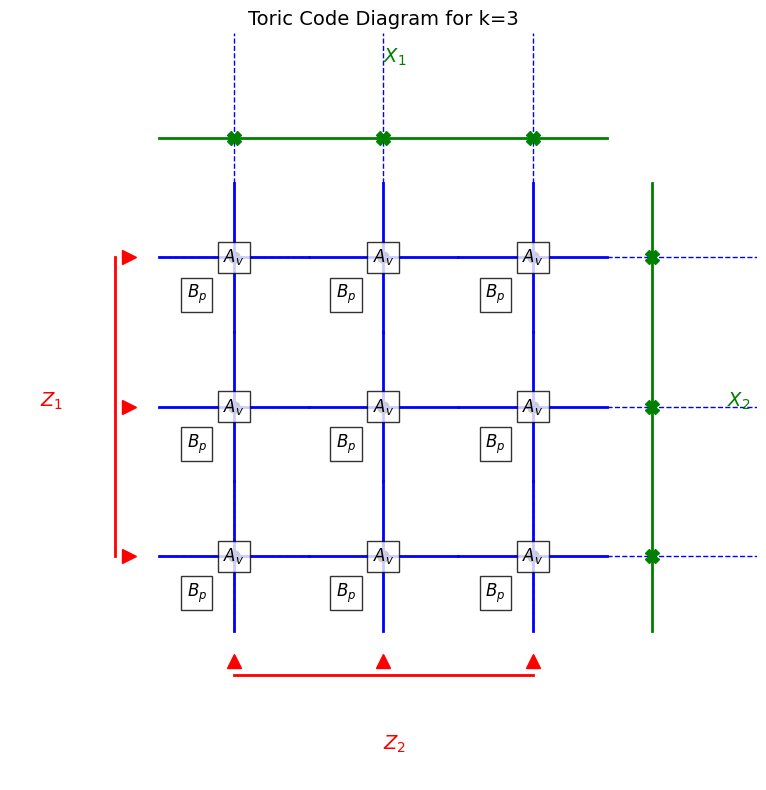


Stabilizer Measurements: ('000000000 000000000', 10)

Logical Measurements: ('00', 10)

Error Correction Results: ('00 000010010 000001001', 10)


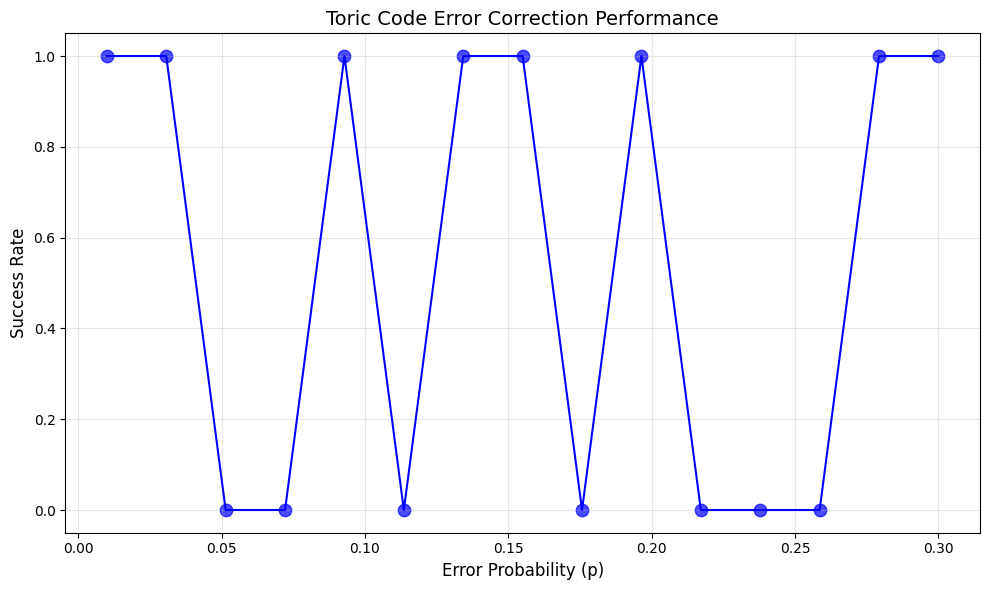


Workflow completed successfully!


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from qiskit import QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, pauli_error

###################################################################
## Helper Functions
###################################################################

def u(r, c, k):
    """Labels unit cells in the toric code lattice at row r and column c (0-indexed)"""
    return (r % k) * k + (c % k)

def norm1(p1, p2, k):
    """Computes Manhattan norm between points p1, p2 on a k×k Toric Code with periodic boundaries"""
    return sum(min(abs(p1[j]-p2[j]), k - abs(p2[j]-p1[j])) for j in range(len(p1)))

def pair_points(points):
    """Generates all possible pairings of points for defect correction"""
    if not points:
        return [[]]
    pairings = []
    first = points[0]
    for i in range(1, len(points)):
        pair = (first, points[i])
        rest = points[1:i] + points[i+1:]
        for subpairing in pair_points(rest):
            pairings.append([pair] + subpairing)
    return pairings

###################################################################
## Quantum Circuit Components
###################################################################

def create_ghz4_gate():
    """Creates a 4-qubit GHZ state preparation gate"""
    qc = QuantumCircuit(4, name="GHZ4")
    qc.h(0)
    qc.cx(0, 1)
    qc.cx(0, 2)
    qc.cx(0, 3)
    return qc.to_gate()

def create_x_measure_gate():
    """Creates gate to measure product of X operators"""
    qc = QuantumCircuit(5, name="X_measure")
    # Control qubits (4)
    qc.h([0,1,2,3])
    # Target ancilla (4)
    for i in range(4):
        qc.cx(i, 4)
    qc.h([0,1,2,3])
    return qc.to_gate()

def create_z_measure_gate():
    """Creates gate to measure product of Z operators"""
    qc = QuantumCircuit(5, name="Z_measure")
    # Control qubits (4)
    for i in range(4):
        qc.cx(i, 4)
    return qc.to_gate()

###################################################################
## Toric Code Functions
###################################################################

def create_prep_TC(k):
    """Creates circuit to generate logical |00⟩ state of k×k Toric Code"""
    n = 2 * k**2
    data_qr = QuantumRegister(n, "q")
    qc = QuantumCircuit(data_qr, name="Prep_TC")
    
    # List qubits for all stabilizers
    A_list = [(2*u(r,c,k), 2*u(r,c,k)+1, 2*u(r-1,c,k), 2*u(r,c-1,k)+1) 
              for r in range(k) for c in range(k)]
    
    # Reorder last row for proper gate application
    for j in range(1, k+1):
        A_list[-j] = A_list[-j][1:] + A_list[-j][:1]
    
    # Create GHZ4 gate
    ghz4_gate = create_ghz4_gate()
    
    # Project onto +1 eigenstate of all Av
    for As in A_list[:-1]:
        qc.append(ghz4_gate, [data_qr[j] for j in As])
    
    return qc

def create_stabilizer_measures(k, data_qr, A_qr, B_qr):
    """Creates circuit for measurement of all stabilizers in k×k Toric Code"""
    qc = QuantumCircuit(data_qr, A_qr, B_qr, name="Stabilizers")
    
    # List qubits for all stabilizers
    A_list = [(2*u(r,c,k), 2*u(r,c,k)+1, 2*u(r-1,c,k), 2*u(r,c-1,k)+1) 
              for r in range(k) for c in range(k)]
    B_list = [(2*u(r,c,k), 2*u(r,c,k)+1, 2*u(r+1,c,k)+1, 2*u(r,c+1,k)) 
              for r in range(k) for c in range(k)]
    
    # Create measurement gates
    x_measure = create_x_measure_gate()
    z_measure = create_z_measure_gate()
    
    # Measure all Av stabilizers
    for n_idx, As in enumerate(A_list):
        qc.append(x_measure, [data_qr[j] for j in As] + [A_qr[n_idx]])
    
    # Measure all Bp stabilizers
    for n_idx, Bs in enumerate(B_list):
        qc.append(z_measure, [data_qr[j] for j in Bs] + [B_qr[n_idx]])
    
    return qc

def create_logical_prep(k, log_state, data_qr):
    """Initializes Toric Code from |00⟩ to |01⟩, |10⟩, or |11⟩"""
    qc = QuantumCircuit(data_qr, name="Logical_Prep")
    
    if log_state != "00":
        X1_bits = [2*u(r,0,k)+1 for r in range(k)]
        X2_bits = [2*u(0,c,k) for c in range(k)]
        
        if log_state in {"01", "11"}:
            qc.x([data_qr[j] for j in X1_bits])
        if log_state in {"10", "11"}:
            qc.x([data_qr[j] for j in X2_bits])
    
    return qc

def create_logical_measure(k, data_qr, Z_qr):
    """Creates circuit to measure logical Z operators"""
    qc = QuantumCircuit(data_qr, Z_qr, name="Logical_Measure")
    
    Z1_bits = [2*u(0,c,k)+1 for c in range(k)]
    Z2_bits = [2*u(r,0,k) for r in range(k)]
    
    # Measure Z1 operator
    for j in Z1_bits:
        qc.cx(data_qr[j], Z_qr[0])
    
    # Measure Z2 operator
    for j in Z2_bits:
        qc.cx(data_qr[j], Z_qr[1])
    
    return qc

def create_random_Pauli_error(k, px, pz, data_qr):
    """Creates random Pauli error channel for k×k Toric Code"""
    qc = QuantumCircuit(data_qr, name="Pauli_Errors")
    
    for i, q in enumerate(data_qr):
        if np.random.rand() < px: 
            qc.x(q)
        if np.random.rand() < pz: 
            qc.z(q)
    
    return qc

###################################################################
## Visualization and Analysis Functions
###################################################################

def plot_toric_code(k=3):
    """Plots the Toric Code diagram showing stabilizers and logical operators"""
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Create grid
    for r in range(k):
        for c in range(k):
            # Vertex at center of each cell
            ax.plot(c + 0.5, r + 0.5, 'ko', markersize=8)
            
            # Edges
            ax.plot([c, c+1], [r+0.5, r+0.5], 'b-', lw=2)  # Horizontal
            ax.plot([c+0.5, c+0.5], [r, r+1], 'b-', lw=2)  # Vertical
    
    # Periodic boundaries
    for r in range(k):
        ax.plot([0, 1], [r+0.5, r+0.5], 'b--', lw=1)  # Left
        ax.plot([k, k+1], [r+0.5, r+0.5], 'b--', lw=1)  # Right
    for c in range(k):
        ax.plot([c+0.5, c+0.5], [0, 1], 'b--', lw=1)  # Bottom
        ax.plot([c+0.5, c+0.5], [k, k+1], 'b--', lw=1)  # Top
    
    # Stabilizers
    for r in range(k):
        for c in range(k):
            # Vertex stabilizer (A_v)
            ax.text(c+0.5, r+0.5, r"$A_v$", fontsize=12, ha='center', va='center', 
                    bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))
            
            # Plaquette stabilizer (B_p)
            ax.text(c+0.25, r+0.25, r"$B_p$", fontsize=12, ha='center', va='center', 
                    bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))
    
    # Logical operators
    # Z1 (vertical loop)
    for r in range(k):
        ax.plot(-0.2, r+0.5, 'r>', markersize=10)
    ax.plot([-0.3, -0.3], [0.5, k-0.5], 'r-', lw=2)
    ax.text(-0.8, k/2, r"$Z_1$", fontsize=14, color='red')
    
    # Z2 (horizontal loop)
    for c in range(k):
        ax.plot(c+0.5, -0.2, 'r^', markersize=10)
    ax.plot([0.5, k-0.5], [-0.3, -0.3], 'r-', lw=2)
    ax.text(k/2, -0.8, r"$Z_2$", fontsize=14, color='red')
    
    # X1 (horizontal dual loop)
    ax.plot([0, k], [k+0.3, k+0.3], 'g-', lw=2)
    for c in range(k):
        ax.plot(c+0.5, k+0.3, 'gX', markersize=10)
    ax.text(k/2, k+0.8, r"$X_1$", fontsize=14, color='green')
    
    # X2 (vertical dual loop)
    ax.plot([k+0.3, k+0.3], [0, k], 'g-', lw=2)
    for r in range(k):
        ax.plot(k+0.3, r+0.5, 'gX', markersize=10)
    ax.text(k+0.8, k/2, r"$X_2$", fontsize=14, color='green')
    
    ax.set_xlim(-1, k+1)
    ax.set_ylim(-1, k+1)
    ax.set_aspect('equal')
    ax.set_title(f"Toric Code Diagram for k={k}", fontsize=14)
    ax.axis('off')
    plt.tight_layout()
    plt.savefig('TC_diagram.png', dpi=300)
    plt.show()

def analyze_success_probability(k, log_state, p_min=0.01, p_max=0.3, points=15, shots=100):
    """Analyzes success probability vs error rate and plots results"""
    # Initialize simulator
    simulator = AerSimulator(method="stabilizer")
    
    # Set up error probability range
    p_arr = np.linspace(p_min, p_max, points)
    prob_arr = []
    
    for p in p_arr:
        # Create noise model
        bit_flip = pauli_error([('X', p), ('Y', p), ('Z', p), ('I', 1 - 3*p)])
        noise = NoiseModel().add_all_qubit_quantum_error(bit_flip, ['id'])
        noisy_sim = AerSimulator(method='stabilizer', noise_model=noise)
        
        # Create quantum registers
        n = k**2
        data_qr = QuantumRegister(2*n, "q")
        A_qr = AncillaRegister(n, "A")
        B_qr = AncillaRegister(n, "B")
        Z_qr = AncillaRegister(2, "Z")
        
        # Classical registers
        A_measures = ClassicalRegister(n, "mA")
        B_measures = ClassicalRegister(n, "mB")
        Z_measures = ClassicalRegister(2, "mZ")
        
        # Create quantum circuit
        qc = QuantumCircuit(data_qr, A_qr, B_qr, Z_qr, A_measures, B_measures, Z_measures)
        
        # Prepare Toric Code
        prep_circuit = create_prep_TC(k)
        qc.compose(prep_circuit, qubits=data_qr, inplace=True)
        
        # Prepare logical state
        logical_prep = create_logical_prep(k, log_state, data_qr)
        qc.compose(logical_prep, qubits=data_qr, inplace=True)
        
        # Add errors
        error_circuit = create_random_Pauli_error(k, p, p, data_qr)
        qc.compose(error_circuit, qubits=data_qr, inplace=True)
        
        # Measure stabilizers
        stab_circuit = create_stabilizer_measures(k, data_qr, A_qr, B_qr)
        qc.compose(stab_circuit, qubits=[*data_qr, *A_qr, *B_qr], inplace=True)
        
        # Measure ancillas
        qc.measure(A_qr, A_measures)
        qc.measure(B_qr, B_measures)
        
        # Measure logical operators
        logical_measure = create_logical_measure(k, data_qr, Z_qr)
        qc.compose(logical_measure, qubits=[*data_qr, *Z_qr], inplace=True)
        qc.measure(Z_qr, Z_measures)
        
        # Execute simulation
        compiled = transpile(qc, noisy_sim)
        result = noisy_sim.run(compiled, shots=shots).result()
        counts = result.get_counts()
        
        # Calculate success rate
        success = 0
        for state, count in counts.items():
            # Extract logical measurement results (last 2 bits)
            logical_result = state[:2]
            if logical_result == log_state:
                success += count
        prob_arr.append(success / shots)
    
    # Plot results
    plt.figure(figsize=(10, 6))
    plt.scatter(p_arr, prob_arr, c='blue', s=80, alpha=0.7)
    plt.plot(p_arr, prob_arr, 'b-', lw=1.5)
    plt.xlabel("Error Probability (p)", fontsize=12)
    plt.ylabel("Success Rate", fontsize=12)
    plt.title("Toric Code Error Correction Performance", fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.ylim(-0.05, 1.05)
    plt.tight_layout()
    plt.savefig('success_probability.png', dpi=300)
    plt.show()
    
    return p_arr, prob_arr

###################################################################
## Main Workflow Functions
###################################################################

def run_main_workflow():
    """Runs the full Toric Code error correction workflow"""
    # Set parameters
    k = 3
    log_state = "00"
    
    # Generate and show Toric Code diagram
    plot_toric_code(k)
    
    # Initialize simulator
    simulator = AerSimulator(method="stabilizer")
    
    # 1. Measure stabilizers on initial state
    n = k**2
    data_qr = QuantumRegister(2*n, "q")
    A_qr = AncillaRegister(n, "A")
    B_qr = AncillaRegister(n, "B")
    A_measures = ClassicalRegister(n, "mA")
    B_measures = ClassicalRegister(n, "mB")
    
    qc = QuantumCircuit(data_qr, A_qr, B_qr, A_measures, B_measures)
    
    # Prepare Toric Code
    prep_circuit = create_prep_TC(k)
    qc.compose(prep_circuit, qubits=data_qr, inplace=True)
    
    # Measure stabilizers
    stab_circuit = create_stabilizer_measures(k, data_qr, A_qr, B_qr)
    qc.compose(stab_circuit, qubits=[*data_qr, *A_qr, *B_qr], inplace=True)
    
    # Measure ancillas
    qc.measure(A_qr, A_measures)
    qc.measure(B_qr, B_measures)
    
    # Execute
    compiled = transpile(qc, simulator)
    result = simulator.run(compiled, shots=10).result()
    counts = result.get_counts()
    print("\nStabilizer Measurements:", list(counts.items())[0])
    
    # 2. Prepare and measure logical states
    data_qr = QuantumRegister(2*n, "q")
    Z_qr = AncillaRegister(2, "Z")
    Z_measures = ClassicalRegister(2, "mZ")
    qc = QuantumCircuit(data_qr, Z_qr, Z_measures)
    
    # Prepare Toric Code
    qc.compose(prep_circuit, qubits=data_qr, inplace=True)
    
    # Prepare logical state
    logical_prep = create_logical_prep(k, log_state, data_qr)
    qc.compose(logical_prep, qubits=data_qr, inplace=True)
    
    # Measure logical operators
    logical_measure = create_logical_measure(k, data_qr, Z_qr)
    qc.compose(logical_measure, qubits=[*data_qr, *Z_qr], inplace=True)
    qc.measure(Z_qr, Z_measures)
    
    # Execute
    compiled = transpile(qc, simulator)
    result = simulator.run(compiled, shots=10).result()
    counts = result.get_counts()
    print("\nLogical Measurements:", list(counts.items())[0])
    
    # 3. Error correction with random errors
    data_qr = QuantumRegister(2*n, "q")
    A_qr = AncillaRegister(n, "A")
    B_qr = AncillaRegister(n, "B")
    Z_qr = AncillaRegister(2, "Z")
    A_measures = ClassicalRegister(n, "mA")
    B_measures = ClassicalRegister(n, "mB")
    Z_measures = ClassicalRegister(2, "mZ")
    
    qc = QuantumCircuit(data_qr, A_qr, B_qr, Z_qr, A_measures, B_measures, Z_measures)
    
    # Prepare Toric Code
    qc.compose(prep_circuit, qubits=data_qr, inplace=True)
    
    # Prepare logical state
    qc.compose(logical_prep, qubits=data_qr, inplace=True)
    
    # Add errors
    error_circuit = create_random_Pauli_error(k, 0.08, 0.08, data_qr)
    qc.compose(error_circuit, qubits=data_qr, inplace=True)
    
    # Measure stabilizers
    stab_circuit = create_stabilizer_measures(k, data_qr, A_qr, B_qr)
    qc.compose(stab_circuit, qubits=[*data_qr, *A_qr, *B_qr], inplace=True)
    qc.measure(A_qr, A_measures)
    qc.measure(B_qr, B_measures)
    
    # Measure logical operators
    logical_measure = create_logical_measure(k, data_qr, Z_qr)
    qc.compose(logical_measure, qubits=[*data_qr, *Z_qr], inplace=True)
    qc.measure(Z_qr, Z_measures)
    
    # Execute
    compiled = transpile(qc, simulator)
    result = simulator.run(compiled, shots=10).result()
    counts = result.get_counts()
    print("\nError Correction Results:", list(counts.items())[0])
    
    # 4. Analyze success probability
    p_arr, prob_arr = analyze_success_probability(k, log_state)
    
    print("\nWorkflow completed successfully!")

###################################################################
## Main Execution
###################################################################

if __name__ == "__main__":
    run_main_workflow()